# 🌤️ Weather Model Training - Dual Model (Hourly + Daily)

Notebook ini mengikuti panduan dari `training_guide.md` untuk melatih **dual-model**:
1. **Model Hourly** - Prediksi per-jam (temp, humidity, windspeed, pressure, weather_code)
2. **Model Daily** - Prediksi per-hari (temp_min, temp_max, temp_mean, humidity_avg, windspeed_avg, pressure_avg, weather_code_dominant)

**Output:** 7 file model `.pkl` untuk berbagai kebutuhan deployment.

## 1. Persiapan Lingkungan dan Pemuatan Pustaka

In [ ]:
# Install dependencies jika belum ada
# !pip install pandas numpy matplotlib seaborn scikit-learn xgboost joblib

In [25]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, f1_score, classification_report, confusion_matrix
)

# Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# XGBoost
try:
    from xgboost import XGBRegressor, XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    print("XGBoost not installed. Skipping XGBoost models.")
    XGBOOST_AVAILABLE = False

# Joblib for saving models
import joblib

print("✅ Semua pustaka berhasil diimpor!")
print(f"   - Pandas: {pd.__version__}")
print(f"   - NumPy: {np.__version__}")
print(f"   - XGBoost Available: {XGBOOST_AVAILABLE}")

✅ Semua pustaka berhasil diimpor!
   - Pandas: 2.2.3
   - NumPy: 1.26.4
   - XGBoost Available: True


## 2. Pengumpulan dan Pemuatan Data

In [26]:
# Load dataset (23 kolom: hourly + daily features)
DATA_PATH = '../data/historical_data_2000_2024.csv'

df = pd.read_csv(DATA_PATH)

# Konversi timestamp ke datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Urutkan berdasarkan waktu (PENTING untuk time-series)
df = df.sort_values('timestamp').reset_index(drop=True)

print(f"📊 Dataset loaded: {len(df):,} baris x {len(df.columns)} kolom")
print(f"📅 Rentang waktu: {df['timestamp'].min()} - {df['timestamp'].max()}")
print(f"\n📋 Kolom dataset:")
print(df.columns.tolist())
df.head()

📊 Dataset loaded: 227,304 baris x 23 kolom
📅 Rentang waktu: 2000-01-01 00:00:00 - 2025-12-05 23:00:00

📋 Kolom dataset:
['id', 'timestamp', 'hour', 'day', 'month', 'year', 'temp', 'humidity', 'windspeed', 'sealevelpressure', 'rain', 'precipitation', 'apparent_temperature', 'surface_pressure', 'weather_code', 'conditions', 'temp_max_daily', 'temp_min_daily', 'weather_code_daily', 'temp_mean_daily', 'humidity_avg_daily', 'pressure_avg_daily', 'windspeed_avg_daily']


,id,timestamp,hour,day,month,year,temp,humidity,windspeed,sealevelpressure,...,surface_pressure,weather_code,conditions,temp_max_daily,temp_min_daily,weather_code_daily,temp_mean_daily,humidity_avg_daily,pressure_avg_daily,windspeed_avg_daily
0,0,2000-01-01 00:00:00,0,1,1,2000,21.8,98,4.0,1008.4,...,984.5,3,Overcast,27.5,20.8,53,24.1,91,1007.3,6.3
1,1,2000-01-01 01:00:00,1,1,1,2000,21.4,99,4.0,1007.9,...,983.9,3,Overcast,27.5,20.8,53,24.1,91,1007.3,6.3
2,2,2000-01-01 02:00:00,2,1,1,2000,21.4,98,3.2,1007.4,...,983.4,3,Overcast,27.5,20.8,53,24.1,91,1007.3,6.3
3,3,2000-01-01 03:00:00,3,1,1,2000,21.2,99,4.6,1007.0,...,983.0,3,Overcast,27.5,20.8,53,24.1,91,1007.3,6.3
4,4,2000-01-01 04:00:00,4,1,1,2000,21.0,99,3.6,1006.9,...,982.9,3,Overcast,27.5,20.8,53,24.1,91,1007.3,6.3


In [27]:
# Info struktur data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227304 entries, 0 to 227303
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    227304 non-null  int64         
 1   timestamp             227304 non-null  datetime64[ns]
 2   hour                  227304 non-null  int64         
 3   day                   227304 non-null  int64         
 4   month                 227304 non-null  int64         
 5   year                  227304 non-null  int64         
 6   temp                  227304 non-null  float64       
 7   humidity              227304 non-null  int64         
 8   windspeed             227304 non-null  float64       
 9   sealevelpressure      227304 non-null  float64       
 10  rain                  227304 non-null  float64       
 11  precipitation         227304 non-null  float64       
 12  apparent_temperature  227304 non-null  float64       
 13 

## 3. Analisis Data Eksplorasi (EDA)

### 3.1 Statistik Deskriptif

In [28]:
# Statistik deskriptif untuk fitur numerik
df.describe()

,id,timestamp,hour,day,month,year,temp,humidity,windspeed,sealevelpressure,...,apparent_temperature,surface_pressure,weather_code,temp_max_daily,temp_min_daily,weather_code_daily,temp_mean_daily,humidity_avg_daily,pressure_avg_daily,windspeed_avg_daily
count,227304.000000,227304,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,...,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000
mean,113651.500000,2012-12-18 11:30:00,11.500000,15.722733,6.507655,2012.465315,25.537435,79.351679,6.158908,1010.092567,...,29.415371,986.395679,17.317702,29.926291,22.183349,46.263858,25.528656,79.358568,1010.092334,6.160775
min,0.000000,2000-01-01 00:00:00,0.000000,1.000000,1.000000,2000.000000,17.000000,16.000000,0.000000,1002.200000,...,17.200000,978.700000,0.000000,23.300000,17.000000,0.000000,22.400000,40.000000,1004.600000,1.700000
25%,56825.750000,2006-06-25 17:45:00,5.750000,8.000000,4.000000,2006.000000,23.200000,71.000000,3.400000,1008.800000,...,27.100000,985.200000,2.000000,28.300000,21.500000,51.000000,24.500000,69.000000,1009.200000,4.300000
50%,113651.500000,2012-12-18 11:30:00,11.500000,16.000000,7.000000,2012.000000,25.000000,83.000000,5.200000,1010.200000,...,29.200000,986.400000,3.000000,29.500000,22.200000,55.000000,25.300000,84.000000,1010.200000,5.500000
75%,170477.250000,2019-06-13 05:15:00,17.250000,23.000000,9.000000,2019.000000,27.500000,93.000000,8.000000,1011.400000,...,31.500000,987.700000,51.000000,31.500000,23.000000,63.000000,26.500000,89.000000,1011.000000,7.200000
max,227303.000000,2025-12-05 23:00:00,23.000000,31.000000,12.000000,2025.000000,37.800000,100.000000,34.700000,1016.800000,...,40.500000,993.000000,65.000000,37.800000,25.400000,65.000000,30.400000,98.000000,1014.800000,26.900000
std,65617.157131,NaN,6.922202,8.802513,3.441529,7.482007,3.021772,16.929004,3.900788,1.867129,...,3.213625,1.793721,23.757623,2.317400,1.166040,23.501871,1.344515,11.826198,1.375177,2.657015


### 3.2 Visualisasi Distribusi

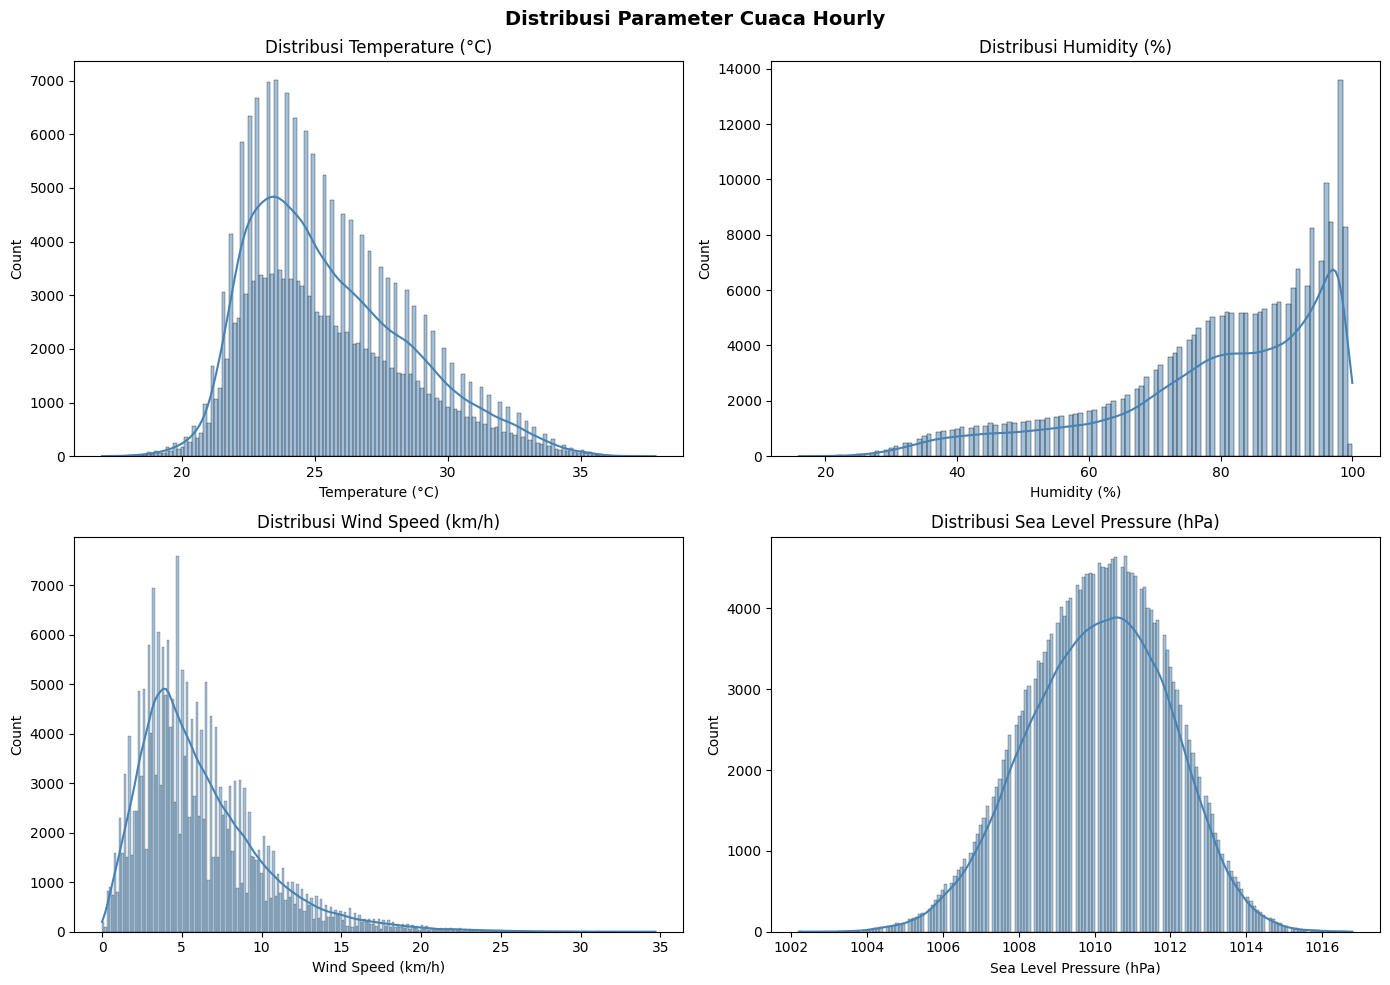

In [29]:
# Visualisasi distribusi parameter cuaca utama (Hourly)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

params = ['temp', 'humidity', 'windspeed', 'sealevelpressure']
titles = ['Temperature (°C)', 'Humidity (%)', 'Wind Speed (km/h)', 'Sea Level Pressure (hPa)']

for ax, param, title in zip(axes.flatten(), params, titles):
    sns.histplot(df[param], kde=True, ax=ax, color='steelblue')
    ax.set_title(f'Distribusi {title}')
    ax.set_xlabel(title)

plt.suptitle('Distribusi Parameter Cuaca Hourly', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

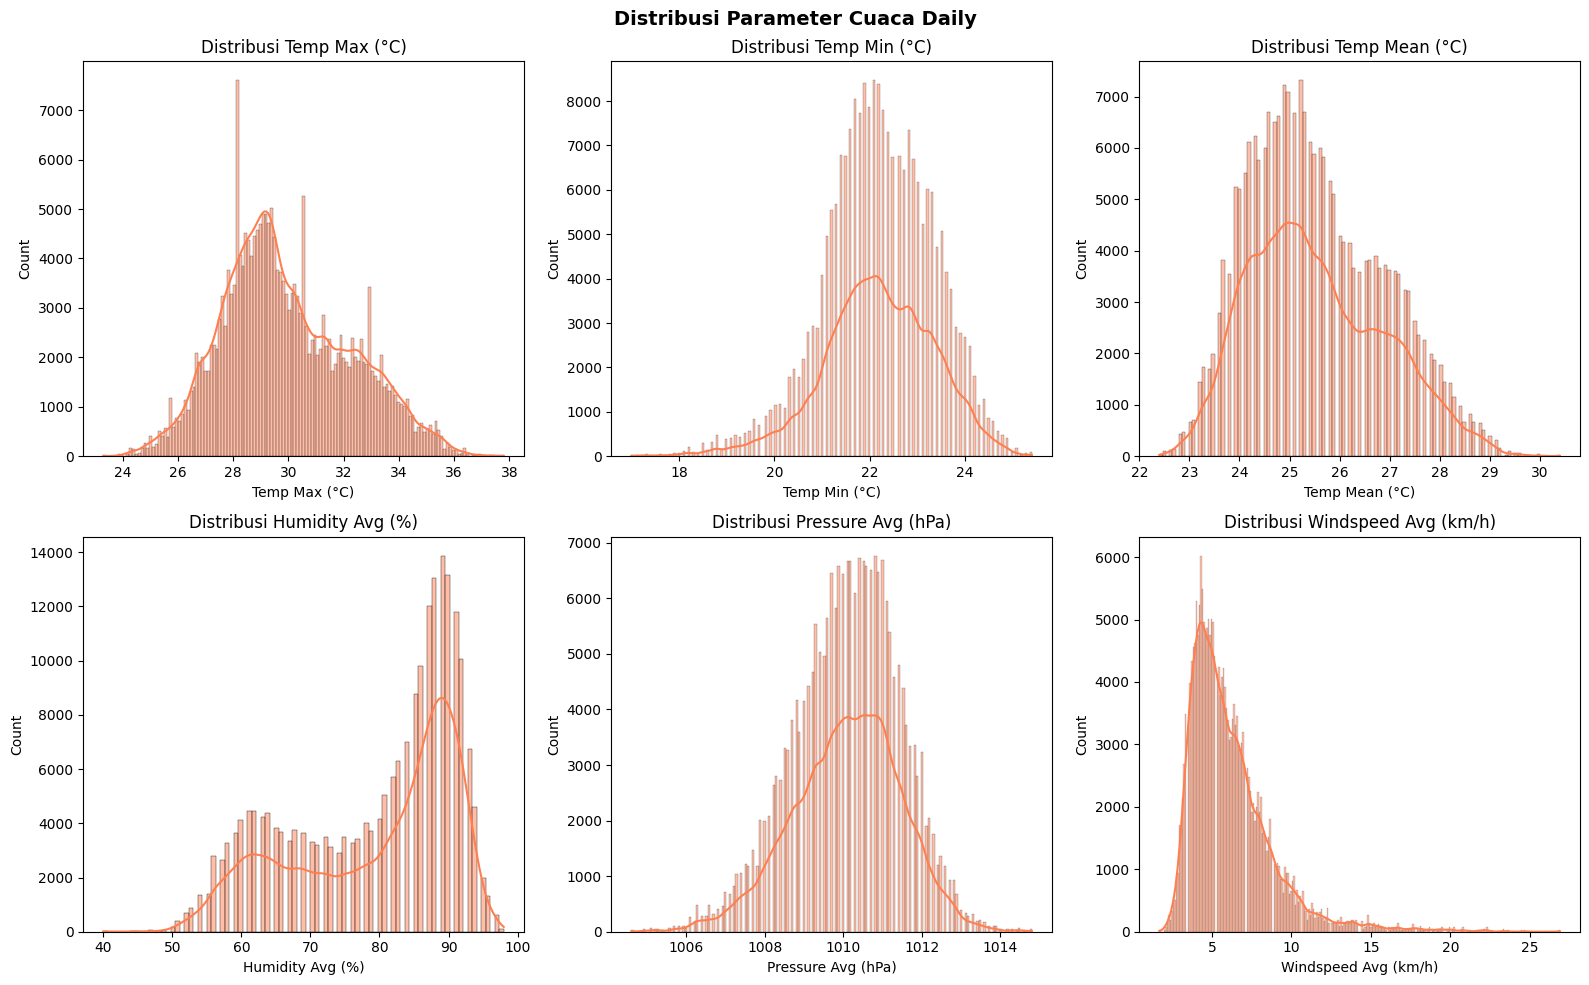

In [30]:
# Visualisasi distribusi parameter cuaca Daily
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

daily_params = ['temp_max_daily', 'temp_min_daily', 'temp_mean_daily', 
                'humidity_avg_daily', 'pressure_avg_daily', 'windspeed_avg_daily']
titles = ['Temp Max (°C)', 'Temp Min (°C)', 'Temp Mean (°C)', 
          'Humidity Avg (%)', 'Pressure Avg (hPa)', 'Windspeed Avg (km/h)']

for ax, param, title in zip(axes.flatten(), daily_params, titles):
    sns.histplot(df[param].dropna(), kde=True, ax=ax, color='coral')
    ax.set_title(f'Distribusi {title}')
    ax.set_xlabel(title)

plt.suptitle('Distribusi Parameter Cuaca Daily', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 3.3 Analisis Korelasi

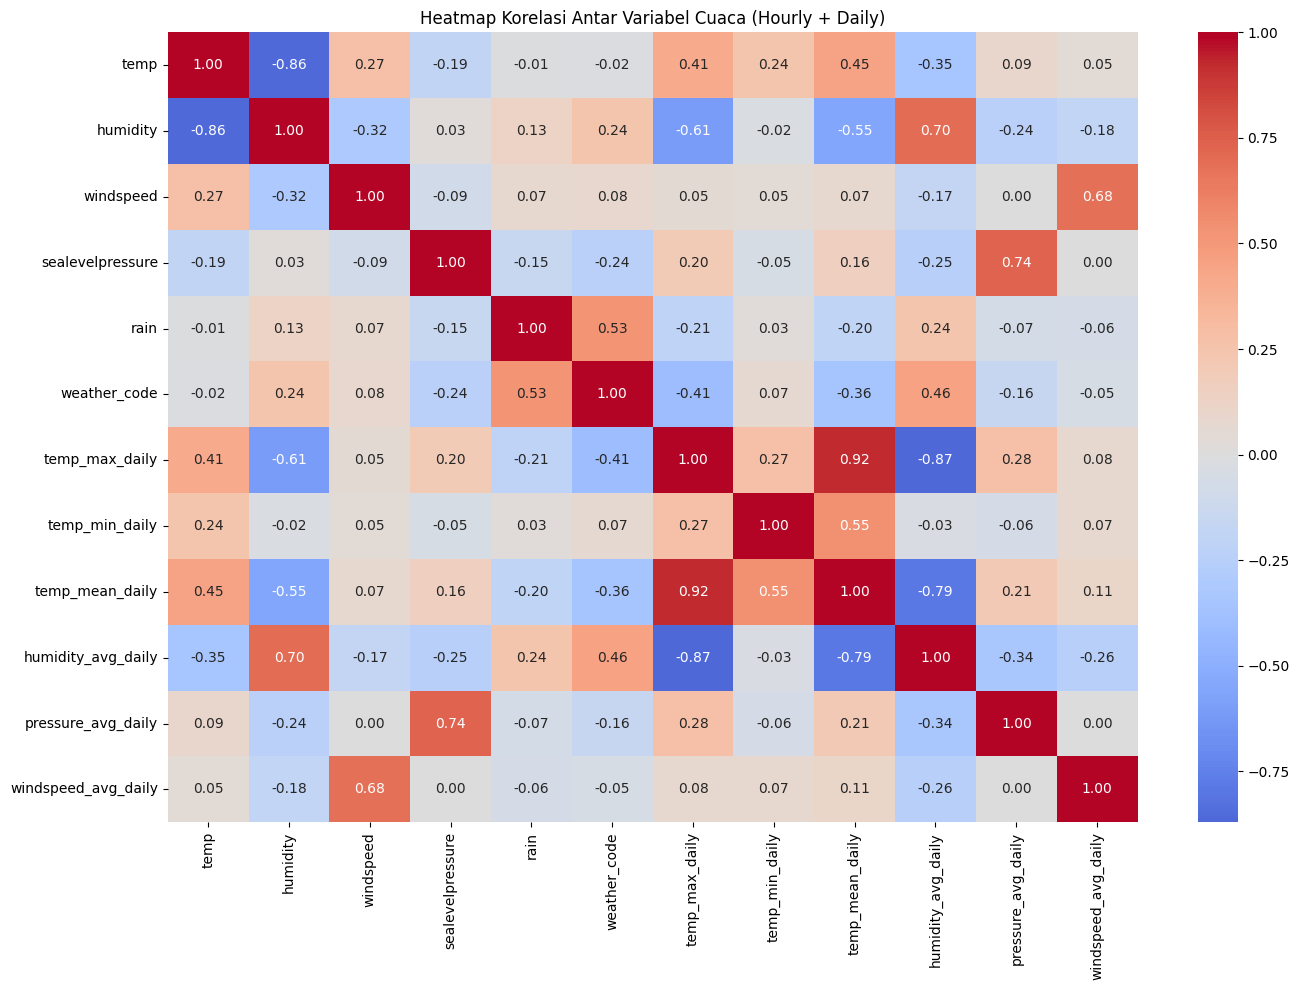

In [31]:
# Heatmap korelasi
numeric_cols = ['temp', 'humidity', 'windspeed', 'sealevelpressure', 'rain', 
                'weather_code', 'temp_max_daily', 'temp_min_daily', 'temp_mean_daily',
                'humidity_avg_daily', 'pressure_avg_daily', 'windspeed_avg_daily']

plt.figure(figsize=(14, 10))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Heatmap Korelasi Antar Variabel Cuaca (Hourly + Daily)')
plt.tight_layout()
plt.show()

### 3.4 Analisis Korelasi: weather_code dan rain

In [32]:
# Analisis hubungan weather_code dengan rain
weather_rain_analysis = df.groupby('weather_code')[['rain']].agg(['mean', 'min', 'max', 'count'])
print("📊 Weather Code vs Rain:")
weather_rain_analysis

📊 Weather Code vs Rain:


rain                  
                   mean  min   max  count
weather_code                             
0              0.000000  0.0   0.0  23299
1              0.000000  0.0   0.0  28622
2              0.000000  0.0   0.0  26366
3              0.000000  0.0   0.0  81996
51             0.205187  0.1   0.4  37111
53             0.661253  0.5   0.9  12419
55             1.091673  1.0   1.2   3783
61             1.743208  1.3   2.4   7332
63             3.948567  2.5   7.5   5792
65            10.288356  7.6  33.4    584

In [33]:
# Verifikasi korelasi deterministik
print(f"\n🔍 Verifikasi rain == precipitation: {(df['rain'] == df['precipitation']).all()}")
print(f"🔍 Weather codes dengan rain > 0: {sorted(df[df['rain'] > 0]['weather_code'].unique())}")
print(f"🔍 Weather codes dengan rain = 0: {sorted(df[df['rain'] == 0]['weather_code'].unique())}")

# Kesimpulan
print("\n✅ KESIMPULAN:")
print("   - rain dan precipitation IDENTIK di seluruh dataset")
print("   - weather_code >= 50 SELALU hujan (deterministik)")
print("   - Tidak perlu memprediksi rain terpisah, cukup prediksi weather_code")


🔍 Verifikasi rain == precipitation: True
🔍 Weather codes dengan rain > 0: [51, 53, 55, 61, 63, 65]
🔍 Weather codes dengan rain = 0: [0, 1, 2, 3]

✅ KESIMPULAN:
   - rain dan precipitation IDENTIK di seluruh dataset
   - weather_code >= 50 SELALU hujan (deterministik)
   - Tidak perlu memprediksi rain terpisah, cukup prediksi weather_code


## 4. Pra-pemrosesan Data dan Feature Engineering

### 4.1 Preprocessing Data Hourly

In [34]:
# Copy dataframe untuk preprocessing
df_hourly = df.copy()

# 1. Label Encoding untuk 'conditions'
le_conditions = LabelEncoder()
df_hourly['conditions_encoded'] = le_conditions.fit_transform(df_hourly['conditions'])

print("📝 Label Encoding untuk 'conditions':")
for i, label in enumerate(le_conditions.classes_):
    print(f"   {i}: {label}")

📝 Label Encoding untuk 'conditions':
   0: Clear
   1: Overcast
   2: Partially cloudy
   3: Rain
   4: Rain, Overcast


In [35]:
# 2. Label Encoding untuk 'weather_code' (PENTING untuk XGBoost)
# XGBoost membutuhkan label berupa integer berurutan (0, 1, 2, ...)
le_weather_code = LabelEncoder()
df_hourly['weather_code_encoded'] = le_weather_code.fit_transform(df_hourly['weather_code'])

print("📝 Label Encoding untuk 'weather_code':")
for i, label in enumerate(le_weather_code.classes_):
    print(f"   {i}: {label}")

📝 Label Encoding untuk 'weather_code':
   0: 0
   1: 1
   2: 2
   3: 3
   4: 51
   5: 53
   6: 55
   7: 61
   8: 63
   9: 65


In [36]:
# 3. Feature Engineering: Lag Features untuk Hourly
hourly_target_cols = ['temp', 'humidity', 'windspeed', 'sealevelpressure']

for col in hourly_target_cols:
    # Lag 1 jam
    df_hourly[f'{col}_lag_1'] = df_hourly[col].shift(1)
    # Lag 24 jam
    df_hourly[f'{col}_lag_24'] = df_hourly[col].shift(24)
    # Rolling mean 24 jam
    df_hourly[f'{col}_rolling_24'] = df_hourly[col].rolling(window=24).mean()

print(f"✅ Feature Engineering Hourly selesai! Kolom baru: {12} fitur lag & rolling")

✅ Feature Engineering Hourly selesai! Kolom baru: 12 fitur lag & rolling


In [37]:
# 4. Hapus baris dengan NaN (akibat lag & rolling)
rows_before = len(df_hourly)
df_hourly = df_hourly.dropna().reset_index(drop=True)
rows_after = len(df_hourly)

print(f"🗑️ Baris dihapus (NaN): {rows_before - rows_after:,}")
print(f"📊 Dataset Hourly final: {rows_after:,} baris")

🗑️ Baris dihapus (NaN): 24
📊 Dataset Hourly final: 227,280 baris


### 4.2 Preprocessing Data Daily

In [38]:
# Agregasi data hourly menjadi daily
df_daily = df.groupby(['year', 'month', 'day']).agg({
    'temp': ['min', 'max', 'mean'],
    'humidity': 'mean',
    'windspeed': 'mean',
    'sealevelpressure': 'mean',
    'weather_code': lambda x: x.mode()[0],  # Dominan weather_code
    'rain': 'sum'  # Total curah hujan
}).reset_index()

# Flatten column names
df_daily.columns = ['year', 'month', 'day', 
                    'temp_min', 'temp_max', 'temp_mean',
                    'humidity_avg', 'windspeed_avg', 'pressure_avg',
                    'weather_code_dominant', 'rain_total']

print(f"📊 Dataset Daily: {len(df_daily):,} baris (hari)")
df_daily.head()

📊 Dataset Daily: 9,471 baris (hari)


,year,month,day,temp_min,temp_max,temp_mean,humidity_avg,windspeed_avg,pressure_avg,weather_code_dominant,rain_total
0,2000,1,1,20.8,27.5,24.154167,90.625000,6.304167,1007.329167,3,4.4
1,2000,1,2,21.6,27.0,23.800000,93.208333,7.504167,1007.254167,51,8.8
2,2000,1,3,22.1,24.9,23.333333,96.916667,5.187500,1007.866667,53,16.1
3,2000,1,4,21.9,27.6,24.291667,89.041667,3.600000,1008.354167,51,4.1
4,2000,1,5,21.3,28.9,24.208333,89.750000,3.800000,1009.054167,3,30.7


In [39]:
# Label Encoding untuk 'weather_code_dominant' (PENTING untuk XGBoost)
le_weather_code_daily = LabelEncoder()
df_daily['weather_code_dominant_encoded'] = le_weather_code_daily.fit_transform(df_daily['weather_code_dominant'])

print("📝 Label Encoding untuk 'weather_code_dominant':")
for i, label in enumerate(le_weather_code_daily.classes_):
    print(f"   {i}: {label}")

📝 Label Encoding untuk 'weather_code_dominant':
   0: 0
   1: 1
   2: 2
   3: 3
   4: 51
   5: 53
   6: 55
   7: 61
   8: 63
   9: 65


In [40]:
# Feature Engineering Daily - Lag Features
df_daily['temp_min_lag_1'] = df_daily['temp_min'].shift(1)   # Kemarin
df_daily['temp_max_lag_1'] = df_daily['temp_max'].shift(1)
df_daily['temp_mean_lag_1'] = df_daily['temp_mean'].shift(1)
df_daily['humidity_avg_lag_1'] = df_daily['humidity_avg'].shift(1)
df_daily['windspeed_avg_lag_1'] = df_daily['windspeed_avg'].shift(1)
df_daily['pressure_avg_lag_1'] = df_daily['pressure_avg'].shift(1)

df_daily['temp_min_lag_7'] = df_daily['temp_min'].shift(7)   # Seminggu lalu
df_daily['temp_max_lag_7'] = df_daily['temp_max'].shift(7)
df_daily['temp_mean_lag_7'] = df_daily['temp_mean'].shift(7)
df_daily['rain_total_lag_1'] = df_daily['rain_total'].shift(1)

# Hapus NaN
rows_before = len(df_daily)
df_daily = df_daily.dropna().reset_index(drop=True)
rows_after = len(df_daily)

print(f"🗑️ Baris dihapus (NaN): {rows_before - rows_after:,}")
print(f"📊 Dataset Daily final: {rows_after:,} baris")

🗑️ Baris dihapus (NaN): 7
📊 Dataset Daily final: 9,464 baris


## 5. Pelatihan dan Perbandingan Model

### 5.1 Pemisahan Data (Time-Series Split)

In [41]:
# ===== HOURLY DATA SPLIT =====
hourly_train_size = int(len(df_hourly) * 0.8)
hourly_train = df_hourly[:hourly_train_size]
hourly_test = df_hourly[hourly_train_size:]

print(f"📊 HOURLY Data Split (80-20):")
print(f"   Train: {len(hourly_train):,} baris")
print(f"   Test:  {len(hourly_test):,} baris")

# ===== DAILY DATA SPLIT =====
daily_train_size = int(len(df_daily) * 0.8)
daily_train = df_daily[:daily_train_size]
daily_test = df_daily[daily_train_size:]

print(f"\n📊 DAILY Data Split (80-20):")
print(f"   Train: {len(daily_train):,} baris")
print(f"   Test:  {len(daily_test):,} baris")

📊 HOURLY Data Split (80-20):
   Train: 181,824 baris
   Test:  45,456 baris

📊 DAILY Data Split (80-20):
   Train: 7,571 baris
   Test:  1,893 baris


In [42]:
# ===== DEFINISI FITUR DAN TARGET =====

# HOURLY Features
hourly_feature_cols = [
    'year', 'month', 'day', 'hour',
    'temp_lag_1', 'temp_lag_24', 'temp_rolling_24',
    'humidity_lag_1', 'humidity_lag_24', 'humidity_rolling_24',
    'windspeed_lag_1', 'windspeed_lag_24', 'windspeed_rolling_24',
    'sealevelpressure_lag_1', 'sealevelpressure_lag_24', 'sealevelpressure_rolling_24'
]
hourly_target_reg = ['temp', 'humidity', 'windspeed', 'sealevelpressure']
hourly_target_clf = 'weather_code_encoded'  # Gunakan encoded untuk XGBoost!

# DAILY Features
daily_feature_cols = [
    'year', 'month', 'day',
    'temp_min_lag_1', 'temp_max_lag_1', 'temp_mean_lag_1',
    'humidity_avg_lag_1', 'windspeed_avg_lag_1', 'pressure_avg_lag_1',
    'temp_min_lag_7', 'temp_max_lag_7', 'temp_mean_lag_7',
    'rain_total_lag_1'
]
daily_target_reg = ['temp_min', 'temp_max', 'temp_mean', 'humidity_avg', 'windspeed_avg', 'pressure_avg']
daily_target_clf = 'weather_code_dominant_encoded'  # Gunakan encoded untuk XGBoost!

# Pisahkan X dan y untuk HOURLY
X_hourly_train = hourly_train[hourly_feature_cols]
X_hourly_test = hourly_test[hourly_feature_cols]
y_hourly_train_reg = hourly_train[hourly_target_reg]
y_hourly_test_reg = hourly_test[hourly_target_reg]
y_hourly_train_clf = hourly_train[hourly_target_clf]
y_hourly_test_clf = hourly_test[hourly_target_clf]

# Pisahkan X dan y untuk DAILY
X_daily_train = daily_train[daily_feature_cols]
X_daily_test = daily_test[daily_feature_cols]
y_daily_train_reg = daily_train[daily_target_reg]
y_daily_test_reg = daily_test[daily_target_reg]
y_daily_train_clf = daily_train[daily_target_clf]
y_daily_test_clf = daily_test[daily_target_clf]

print(f"✅ HOURLY Features: {len(hourly_feature_cols)} | Targets Reg: {hourly_target_reg} | Target Clf: {hourly_target_clf}")
print(f"✅ DAILY Features: {len(daily_feature_cols)} | Targets Reg: {daily_target_reg} | Target Clf: {daily_target_clf}")

✅ HOURLY Features: 16 | Targets Reg: ['temp', 'humidity', 'windspeed', 'sealevelpressure'] | Target Clf: weather_code_encoded
✅ DAILY Features: 13 | Targets Reg: ['temp_min', 'temp_max', 'temp_mean', 'humidity_avg', 'windspeed_avg', 'pressure_avg'] | Target Clf: weather_code_dominant_encoded


### 5.2 Komparasi Model Regresi (Hourly)

In [43]:
# Definisi model regresi
regression_models = {
    'Linear Regression': LinearRegression(),
    'K-Neighbors': KNeighborsRegressor(n_neighbors=5),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
}

if XGBOOST_AVAILABLE:
    regression_models['XGBoost'] = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)

# Fungsi evaluasi
def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

In [44]:
# Training HOURLY Regression Models
print("="*70)
print("🔄 TRAINING HOURLY REGRESSION MODELS")
print("="*70)

hourly_reg_results = []

for name, model in regression_models.items():
    print(f"\n🔄 Training {name}...")
    model.fit(X_hourly_train, y_hourly_train_reg)
    y_pred = model.predict(X_hourly_test)
    
    overall_metrics = evaluate_regression(y_hourly_test_reg, y_pred)
    overall_metrics['Model'] = name
    hourly_reg_results.append(overall_metrics)
    
    print(f"   ✅ {name} - R²: {overall_metrics['R2']:.4f}, RMSE: {overall_metrics['RMSE']:.4f}")

df_hourly_reg = pd.DataFrame(hourly_reg_results).sort_values('R2', ascending=False)
print("\n📊 HASIL PERBANDINGAN REGRESI HOURLY:")
display(df_hourly_reg[['Model', 'R2', 'RMSE', 'MAE']].reset_index(drop=True))

best_hourly_reg_model = df_hourly_reg.iloc[0]['Model']
print(f"\n🏆 MODEL TERBAIK REGRESI HOURLY: {best_hourly_reg_model}")

🔄 TRAINING HOURLY REGRESSION MODELS

🔄 Training Linear Regression...
   ✅ Linear Regression - R²: 0.9010, RMSE: 2.2574

🔄 Training K-Neighbors...
   ✅ K-Neighbors - R²: 0.7959, RMSE: 2.4730

🔄 Training Decision Tree...
   ✅ Decision Tree - R²: 0.7839, RMSE: 2.4445

🔄 Training Random Forest...
   ✅ Random Forest - R²: 0.8932, RMSE: 2.0975

🔄 Training XGBoost...
   ✅ XGBoost - R²: 0.9221, RMSE: 2.0198

📊 HASIL PERBANDINGAN REGRESI HOURLY:


,Model,R2,RMSE,MAE
0,XGBoost,0.922140,2.019782,1.145377
1,Linear Regression,0.901014,2.257361,1.297834
2,Random Forest,0.893161,2.097466,1.267260
3,K-Neighbors,0.795949,2.472985,1.615477
4,Decision Tree,0.783874,2.444513,1.591351



🏆 MODEL TERBAIK REGRESI HOURLY: XGBoost


### 5.3 Komparasi Model Klasifikasi (Hourly)

In [45]:
# Definisi model klasifikasi
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
}

if XGBOOST_AVAILABLE:
    # XGBoost membutuhkan num_class untuk multiclass klasifikasi
    num_classes_hourly = len(le_weather_code.classes_)
    classification_models['XGBoost'] = XGBClassifier(
        n_estimators=100, 
        random_state=42, 
        n_jobs=-1, 
        verbosity=0,
        objective='multi:softmax',
        num_class=num_classes_hourly
    )

In [46]:
# Training HOURLY Classification Models
print("="*70)
print("🔄 TRAINING HOURLY CLASSIFICATION MODELS")
print("="*70)

hourly_clf_results = []

for name, model in classification_models.items():
    print(f"\n🔄 Training {name}...")
    model.fit(X_hourly_train, y_hourly_train_clf)
    y_pred = model.predict(X_hourly_test)
    
    accuracy = accuracy_score(y_hourly_test_clf, y_pred)
    f1_weighted = f1_score(y_hourly_test_clf, y_pred, average='weighted', zero_division=0)
    
    hourly_clf_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1 (Weighted)': f1_weighted
    })
    
    print(f"   ✅ {name} - Accuracy: {accuracy:.4f}, F1: {f1_weighted:.4f}")

df_hourly_clf = pd.DataFrame(hourly_clf_results).sort_values('Accuracy', ascending=False)
print("\n📊 HASIL PERBANDINGAN KLASIFIKASI HOURLY:")
display(df_hourly_clf.reset_index(drop=True))

best_hourly_clf_model = df_hourly_clf.iloc[0]['Model']
print(f"\n🏆 MODEL TERBAIK KLASIFIKASI HOURLY: {best_hourly_clf_model}")

🔄 TRAINING HOURLY CLASSIFICATION MODELS

🔄 Training Logistic Regression...
   ✅ Logistic Regression - Accuracy: 0.4385, F1: 0.3371

🔄 Training Decision Tree...
   ✅ Decision Tree - Accuracy: 0.4189, F1: 0.3651

🔄 Training Random Forest...
   ✅ Random Forest - Accuracy: 0.4429, F1: 0.3853

🔄 Training XGBoost...
   ✅ XGBoost - Accuracy: 0.4467, F1: 0.3926

📊 HASIL PERBANDINGAN KLASIFIKASI HOURLY:


,Model,Accuracy,F1 (Weighted)
0,XGBoost,0.446718,0.392599
1,Random Forest,0.442912,0.385332
2,Logistic Regression,0.438512,0.337142
3,Decision Tree,0.418889,0.365137



🏆 MODEL TERBAIK KLASIFIKASI HOURLY: XGBoost


### 5.4 Komparasi Model Regresi (Daily)

In [47]:
# Training DAILY Regression Models
print("="*70)
print("🔄 TRAINING DAILY REGRESSION MODELS")
print("="*70)

daily_reg_results = []

# Re-initialize models
regression_models_daily = {
    'Linear Regression': LinearRegression(),
    'K-Neighbors': KNeighborsRegressor(n_neighbors=5),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
}
if XGBOOST_AVAILABLE:
    regression_models_daily['XGBoost'] = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)

for name, model in regression_models_daily.items():
    print(f"\n🔄 Training {name}...")
    model.fit(X_daily_train, y_daily_train_reg)
    y_pred = model.predict(X_daily_test)
    
    overall_metrics = evaluate_regression(y_daily_test_reg, y_pred)
    overall_metrics['Model'] = name
    daily_reg_results.append(overall_metrics)
    
    print(f"   ✅ {name} - R²: {overall_metrics['R2']:.4f}, RMSE: {overall_metrics['RMSE']:.4f}")

df_daily_reg = pd.DataFrame(daily_reg_results).sort_values('R2', ascending=False)
print("\n📊 HASIL PERBANDINGAN REGRESI DAILY:")
display(df_daily_reg[['Model', 'R2', 'RMSE', 'MAE']].reset_index(drop=True))

best_daily_reg_model = df_daily_reg.iloc[0]['Model']
print(f"\n🏆 MODEL TERBAIK REGRESI DAILY: {best_daily_reg_model}")

🔄 TRAINING DAILY REGRESSION MODELS

🔄 Training Linear Regression...
   ✅ Linear Regression - R²: 0.7042, RMSE: 2.0658

🔄 Training K-Neighbors...
   ✅ K-Neighbors - R²: 0.4355, RMSE: 2.3691

🔄 Training Decision Tree...
   ✅ Decision Tree - R²: 0.4306, RMSE: 2.6040

🔄 Training Random Forest...
   ✅ Random Forest - R²: 0.6489, RMSE: 2.1004

🔄 Training XGBoost...
   ✅ XGBoost - R²: 0.6470, RMSE: 2.2292

📊 HASIL PERBANDINGAN REGRESI DAILY:


,Model,R2,RMSE,MAE
0,Linear Regression,0.704166,2.065832,1.158164
1,Random Forest,0.648870,2.100399,1.215620
2,XGBoost,0.646980,2.229232,1.265004
3,K-Neighbors,0.435540,2.369066,1.422129
4,Decision Tree,0.430577,2.604027,1.485472



🏆 MODEL TERBAIK REGRESI DAILY: Linear Regression


### 5.5 Komparasi Model Klasifikasi (Daily)

In [48]:
# Training DAILY Classification Models
print("="*70)
print("🔄 TRAINING DAILY CLASSIFICATION MODELS")
print("="*70)

daily_clf_results = []

# Re-initialize models
num_classes_daily = len(le_weather_code_daily.classes_)
classification_models_daily = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
}
if XGBOOST_AVAILABLE:
    classification_models_daily['XGBoost'] = XGBClassifier(
        n_estimators=100, 
        random_state=42, 
        n_jobs=-1, 
        verbosity=0,
        objective='multi:softmax',
        num_class=num_classes_daily
    )

for name, model in classification_models_daily.items():
    print(f"\n🔄 Training {name}...")
    model.fit(X_daily_train, y_daily_train_clf)
    y_pred = model.predict(X_daily_test)
    
    accuracy = accuracy_score(y_daily_test_clf, y_pred)
    f1_weighted = f1_score(y_daily_test_clf, y_pred, average='weighted', zero_division=0)
    
    daily_clf_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1 (Weighted)': f1_weighted
    })
    
    print(f"   ✅ {name} - Accuracy: {accuracy:.4f}, F1: {f1_weighted:.4f}")

df_daily_clf = pd.DataFrame(daily_clf_results).sort_values('Accuracy', ascending=False)
print("\n📊 HASIL PERBANDINGAN KLASIFIKASI DAILY:")
display(df_daily_clf.reset_index(drop=True))

best_daily_clf_model = df_daily_clf.iloc[0]['Model']
print(f"\n🏆 MODEL TERBAIK KLASIFIKASI DAILY: {best_daily_clf_model}")

🔄 TRAINING DAILY CLASSIFICATION MODELS

🔄 Training Logistic Regression...
   ✅ Logistic Regression - Accuracy: 0.6498, F1: 0.5503

🔄 Training Decision Tree...
   ✅ Decision Tree - Accuracy: 0.5637, F1: 0.5478

🔄 Training Random Forest...
   ✅ Random Forest - Accuracy: 0.6297, F1: 0.5659

🔄 Training XGBoost...
   ✅ XGBoost - Accuracy: 0.5674, F1: 0.5597

📊 HASIL PERBANDINGAN KLASIFIKASI DAILY:


,Model,Accuracy,F1 (Weighted)
0,Logistic Regression,0.649762,0.550287
1,Random Forest,0.629688,0.565924
2,XGBoost,0.567353,0.559688
3,Decision Tree,0.563656,0.547820



🏆 MODEL TERBAIK KLASIFIKASI DAILY: Logistic Regression


### 5.6 Kesimpulan Pemilihan Model

In [49]:
print("="*70)
print("🎯 KESIMPULAN PEMILIHAN MODEL TERBAIK")
print("="*70)

print("\n📈 MODEL HOURLY:")
print(f"   🏆 Regresi: {best_hourly_reg_model} (R²: {df_hourly_reg.iloc[0]['R2']:.4f})")
print(f"   🏆 Klasifikasi: {best_hourly_clf_model} (Acc: {df_hourly_clf.iloc[0]['Accuracy']:.4f})")

print("\n📊 MODEL DAILY:")
print(f"   🏆 Regresi: {best_daily_reg_model} (R²: {df_daily_reg.iloc[0]['R2']:.4f})")
print(f"   🏆 Klasifikasi: {best_daily_clf_model} (Acc: {df_daily_clf.iloc[0]['Accuracy']:.4f})")

print("\n" + "="*70)
print("✅ Langkah selanjutnya: Retraining dengan 100% data, lalu simpan 7 file model")
print("="*70)

🎯 KESIMPULAN PEMILIHAN MODEL TERBAIK

📈 MODEL HOURLY:
   🏆 Regresi: XGBoost (R²: 0.9221)
   🏆 Klasifikasi: XGBoost (Acc: 0.4467)

📊 MODEL DAILY:
   🏆 Regresi: Linear Regression (R²: 0.7042)
   🏆 Klasifikasi: Logistic Regression (Acc: 0.6498)

✅ Langkah selanjutnya: Retraining dengan 100% data, lalu simpan 7 file model


## Rangkuman

Notebook ini telah menyelesaikan:

1. ✅ **Persiapan Lingkungan** - Import semua pustaka
2. ✅ **Pemuatan Data** - Load dataset 23 kolom (hourly + daily features)
3. ✅ **EDA** - Analisis distribusi, korelasi, hubungan weather_code dengan rain
4. ✅ **Feature Engineering** - Lag features untuk Hourly dan Daily
5. ✅ **Perbandingan Model** - 5 model regresi & 4 model klasifikasi untuk Hourly dan Daily

**PENTING:** Label `weather_code` dan `weather_code_dominant` telah di-encode menggunakan `LabelEncoder` untuk kompatibilitas dengan XGBoost. Gunakan `label_encoder.inverse_transform()` untuk mendapatkan nilai asli saat inferensi.